In [1]:
%matplotlib widget

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ProcessResults import *
from DatasetTester import *
from GetLandmarks import GetLandmarks 
#from LandmarkTester_alt import LandmarkTester

from landmark_utils import vis_landmarks, compare_landmarks
from vis_utils import *


import cv2
import numpy as np
import time
import timeit
from pathlib import Path
import csv
import pickle

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from scipy import linalg
import seaborn as sns

In [2]:
MEEI_path = Path('./MEEI_Standard_Set')
pat_info = pd.read_excel(MEEI_path/"pat_info.xlsx", sheet_name='Sheet1')

In [3]:
pat_info = pd.read_pickle('MEEI_pat_info.pkl')

with open('all_pats_processed_data.pickle','rb') as f:
    loaded_pats = pickle.load(f)

In [4]:
pat_info

,Category,Sub-category,#,Side,Gender,Age,Path,HB_scale
0,Flaccid,Complete,1,Left,Male,54,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
1,Flaccid,Complete,2,Right,Female,16,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
2,Flaccid,Complete,3,Right,Male,38,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
3,Flaccid,Complete,4,Left,Female,31,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
4,Flaccid,Complete,5,Left,Female,52,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
5,Flaccid,Mild,1,Left,Male,72,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
6,Flaccid,Mild,2,Right,Female,55,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
7,Flaccid,Mild,3,Left,Male,75,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
8,Flaccid,Moderate,1,Left,Male,51,MEEI_Standard_Set/Flaccid/ModerateFlaccid/Mode...,4
9,Flaccid,Moderate,3,Left,Female,62,MEEI_Standard_Set/Flaccid/ModerateFlaccid/Mode...,4


In [5]:
# x - choose one
all_ids = loaded_pats[0]
all_imgs = loaded_pats[1]
all_lms = loaded_pats[2]
all_features = loaded_pats[3]

# y
all_hb = loaded_pats[4]

In [6]:
# Find NaN and Inf values
bad_indices = np.where(np.isnan(all_features).sum(axis=1) > 0)[0]
bad_indices = np.append(bad_indices, np.where(np.isinf(all_features).sum(axis=1) > 0)[0])
bad_indices.sort()
bad_indices

array([], dtype=int64)

In [7]:
# drop bad indices 
# x
all_ids = np.delete(all_ids, bad_indices, axis=0)
all_imgs = np.delete(all_imgs, bad_indices, axis=0)
all_lms = np.delete(all_lms, bad_indices, axis=0)
all_features = np.delete(all_features, bad_indices, axis=0)

# y
all_hb = np.delete(all_hb, bad_indices, axis=0)

all_features.shape, all_hb.shape

((408, 29), (408,))

In [8]:
plot_df = pd.DataFrame(all_features, columns = ['f'+str(i) for i in range(0, 29)])

In [9]:
plot_df['hb'] = all_hb

In [10]:
def feature_plot(df, which_feature, group_by):
    sns.displot(df, x=which_feature, hue=group_by, element="step")
    

/opt/anaconda/envs/bp/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


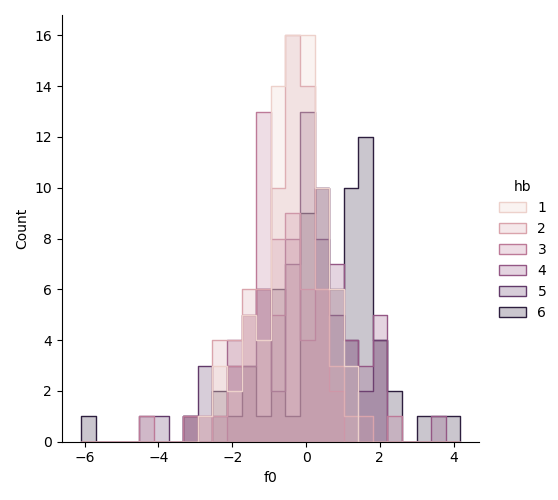

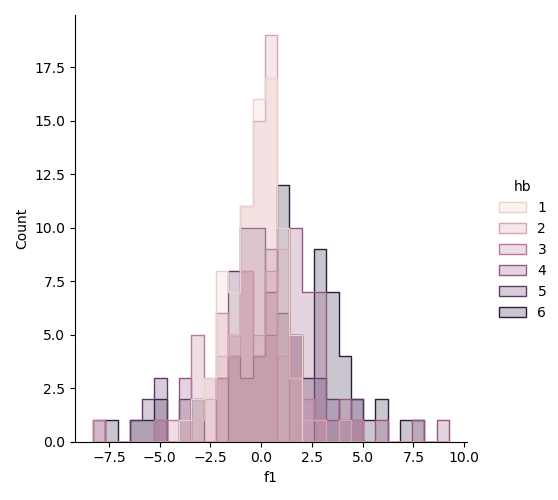

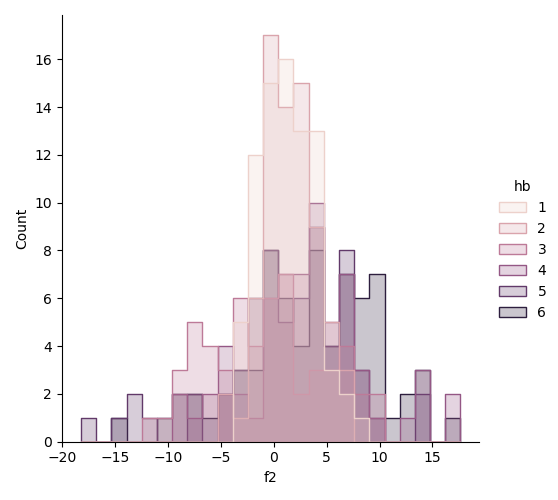

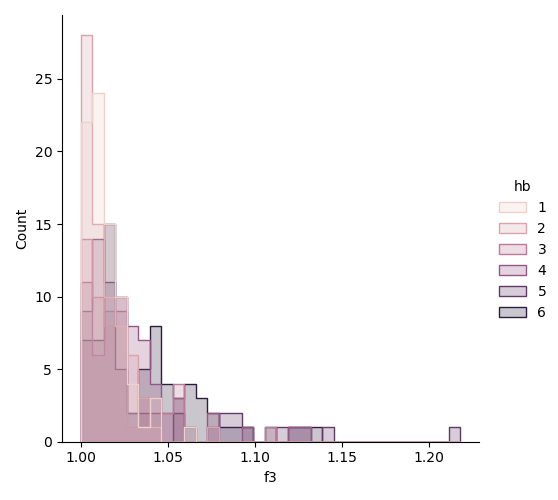

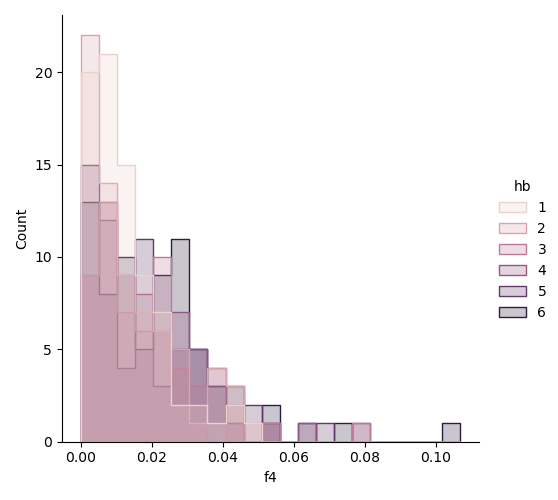

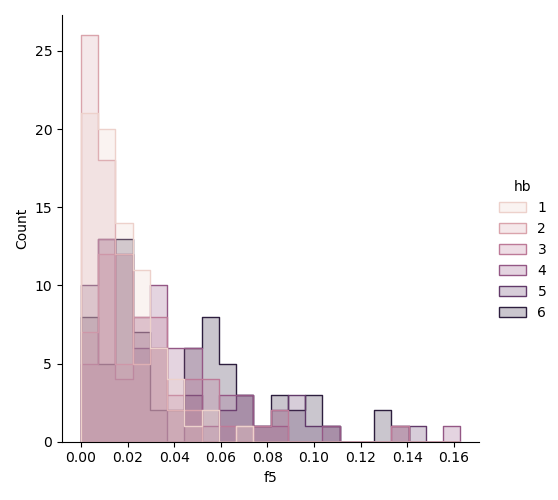

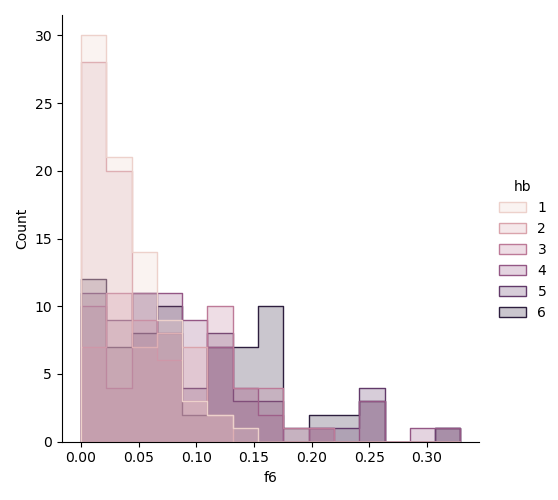

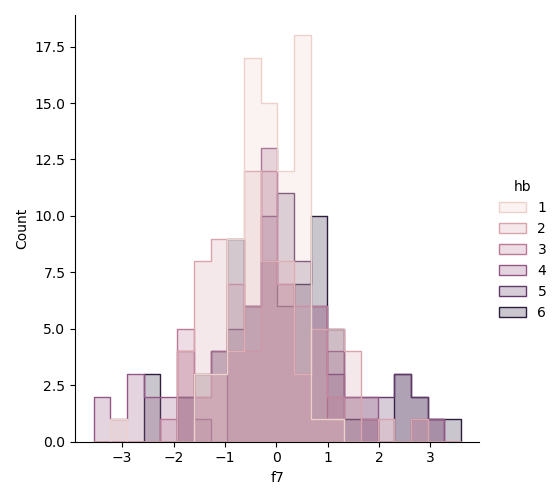

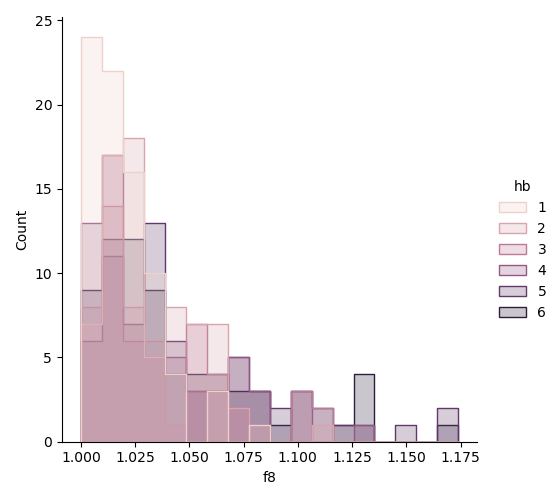

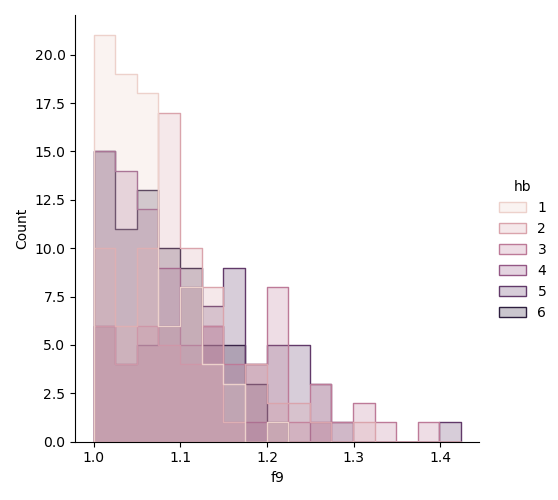

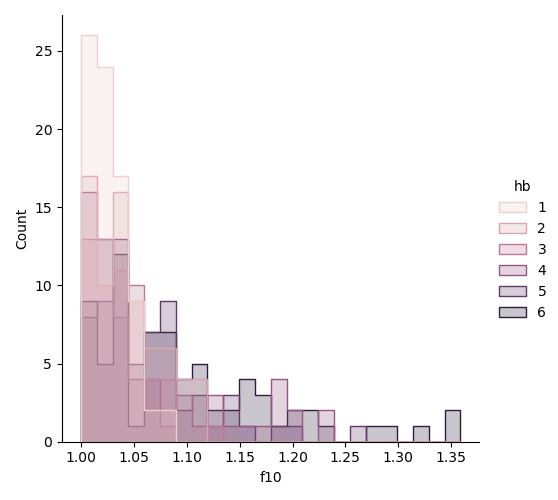

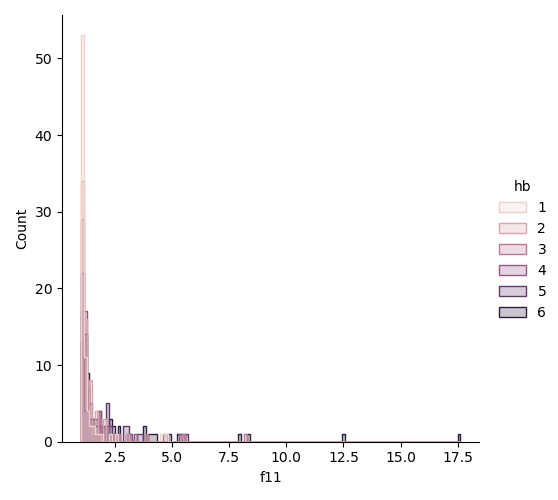

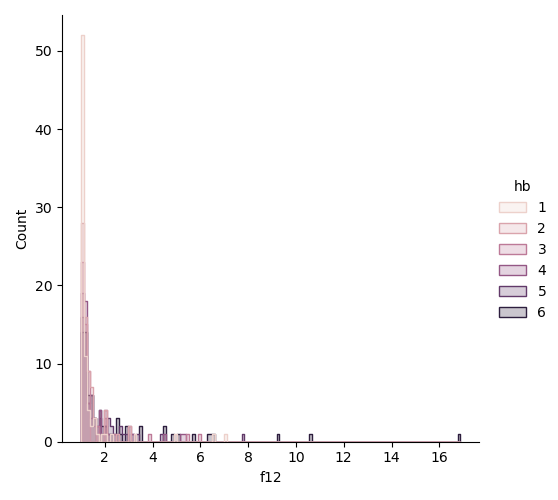

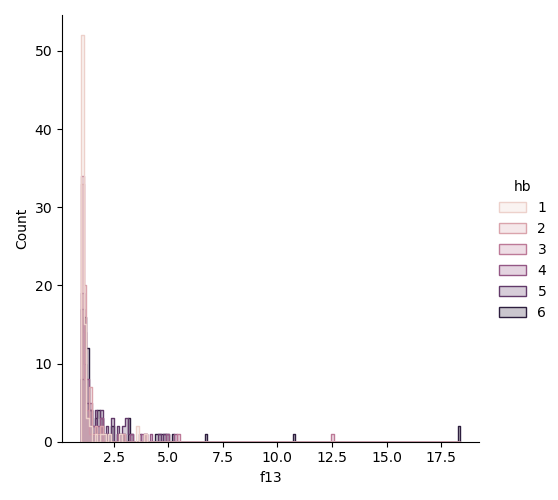

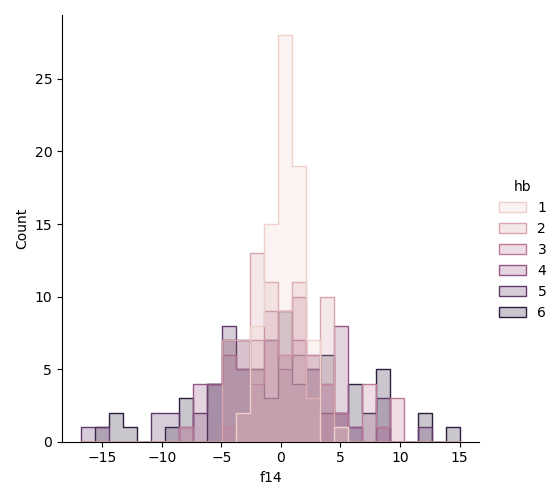

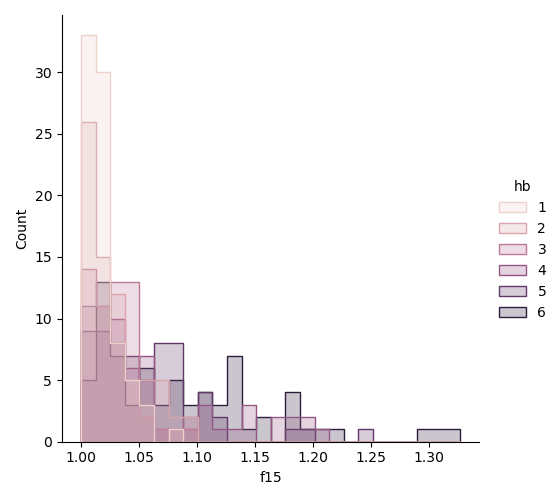

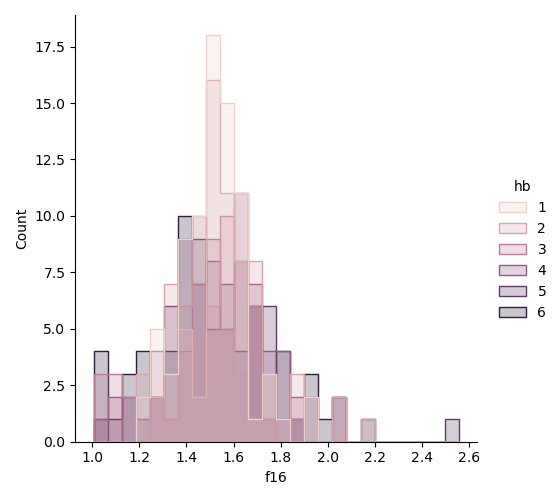

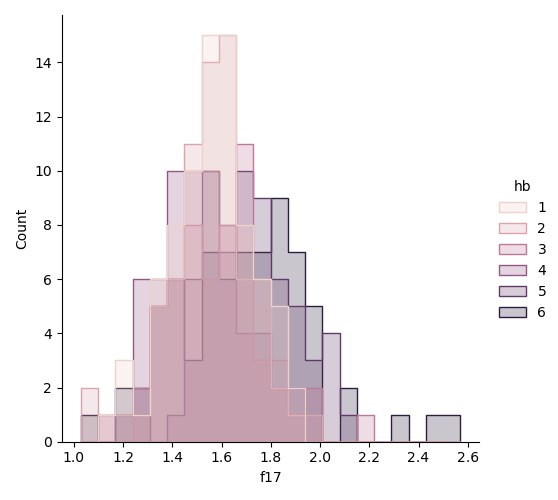

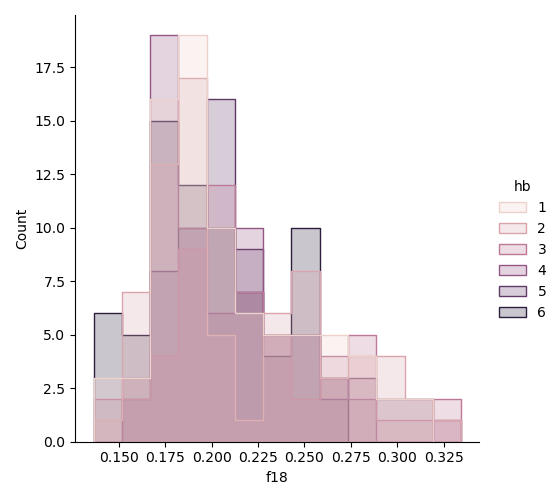

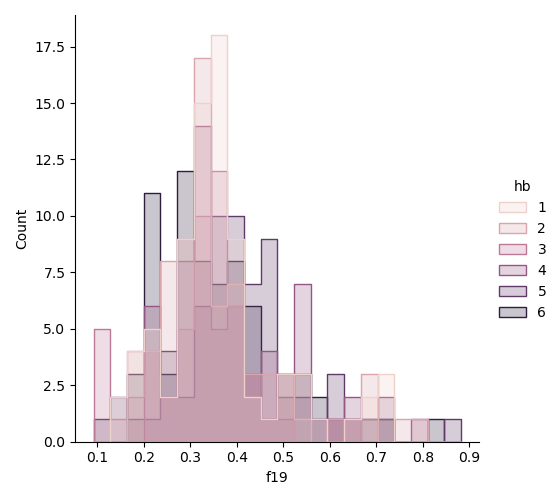

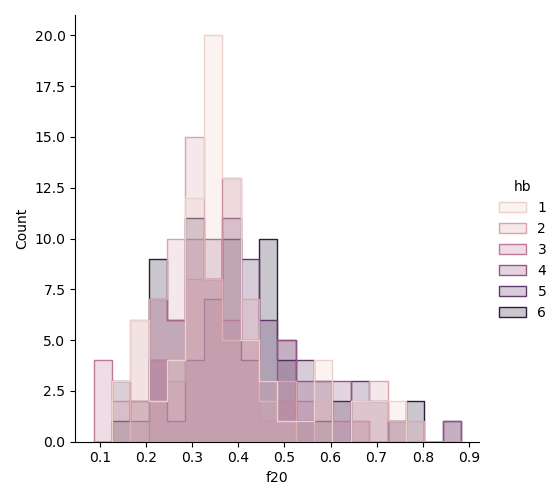

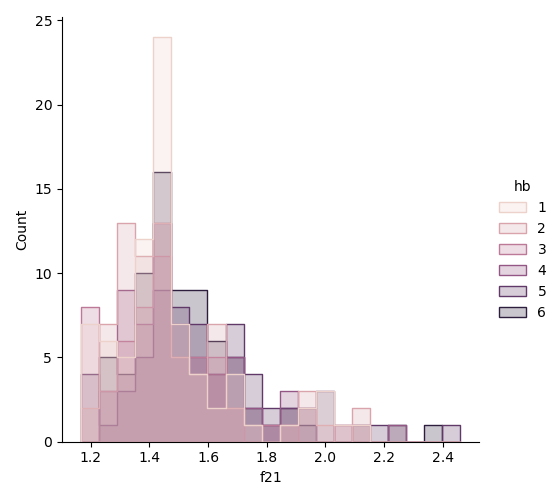

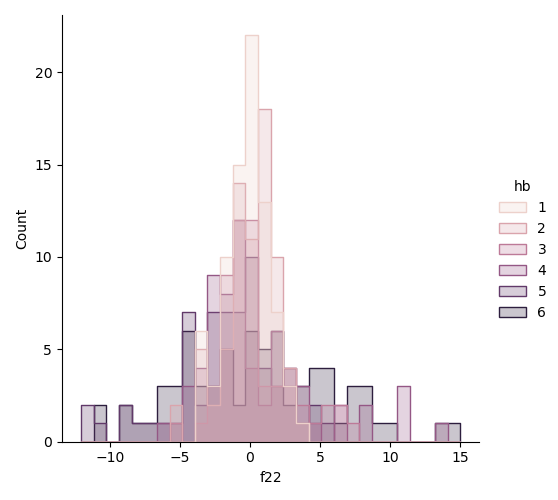

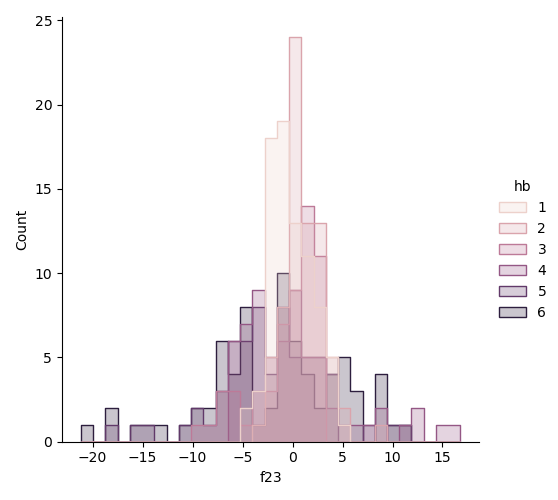

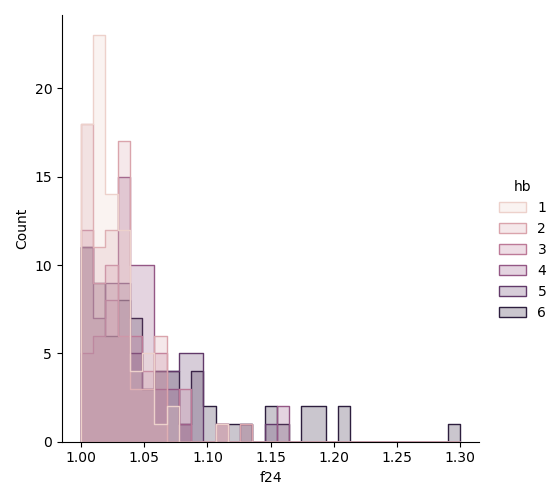

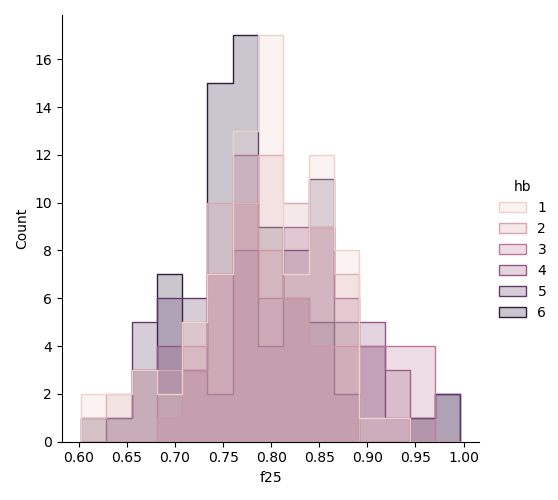

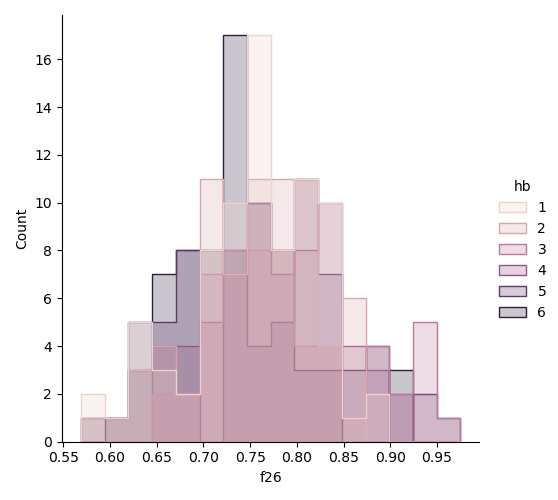

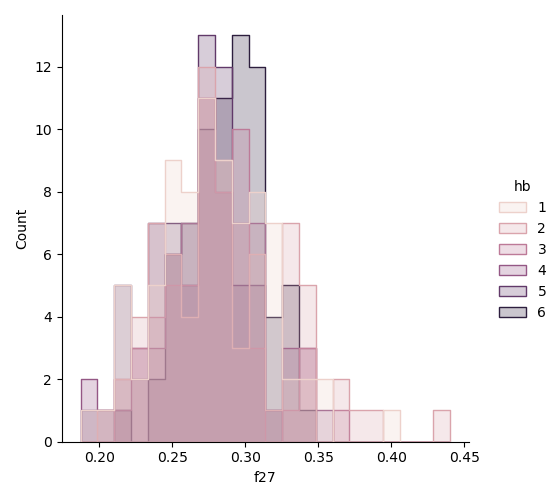

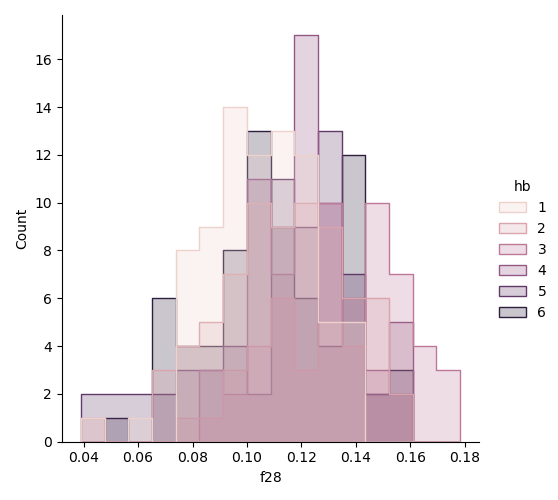

In [11]:
for i in range(0, 29):
    feature_plot(plot_df, 'f'+str(i), 'hb')

In [12]:
# Split IDs into train and test
random.seed(85)
subject_ids = [i for i in range(51)]
train_ids = np.sort(np.array(random.sample(subject_ids, 42)))
test_ids = np.sort(np.array([i for i in subject_ids if i not in train_ids]))

print('Training IDs:',train_ids)
print('Testing IDs:',test_ids)

Training IDs: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 19 20 21 22 24 27 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 49 50]
Testing IDs: [ 1 16 17 18 23 25 26 28 45]


In [13]:
# Next, match the IDs to the indices in the data
train_idx = np.sort(np.where(np.isin(all_ids, train_ids))[0])
test_idx = np.sort(np.where(np.isin(all_ids, test_ids))[0])

x_train, x_test = all_features[train_idx], all_features[test_idx]
y_train, y_test = all_hb[train_idx], all_hb[test_idx]

print('Training x shape:', x_train.shape)
print('Training y shape:', y_train.shape)
print('Testing x shape:', x_test.shape)
print('Testing y shape:', y_test.shape)

Training x shape: (336, 29)
Training y shape: (336,)
Testing x shape: (72, 29)
Testing y shape: (72,)


In [14]:
x_train[0], y_train[0]

(array([  1.645194  ,   2.8099802 ,  12.804038  ,   1.0514685 ,
          0.02872195,   0.04908276,   0.22726855,   2.5692458 ,
          1.0851028 ,   1.0569661 ,   1.3587397 ,   2.0853906 ,
          1.976551  ,   2.200217  , -14.76165   ,   1.2982798 ,
          1.564689  ,   1.6300427 ,   0.1822432 ,   0.43270245,
          0.4529679 ,   1.7084181 , -11.120797  , -18.251646  ,
          1.0966494 ,   0.7621016 ,   0.7131144 ,   0.29012558,
          0.12468714], dtype=float32),
 6)

In [15]:
x_test[0], y_test[0]

(array([ 2.1688318 ,  5.7567234 ,  7.4379115 ,  1.0764056 ,  0.03787135,
         0.10081324,  0.13055022,  0.7424527 ,  1.0363585 ,  1.0367308 ,
         1.0354205 ,  1.1157125 ,  1.0958147 ,  1.1368102 ,  2.7387393 ,
         1.0146147 ,  1.5828909 ,  1.4162164 ,  0.16872515,  0.3655438 ,
         0.351555  ,  1.3814355 , -0.09058161, -0.2640291 ,  1.0116374 ,
         0.78680843,  0.7529882 ,  0.268227  ,  0.11025678], dtype=float32),
 6)

In [16]:
data_dmatrix = xgb.DMatrix(data=all_features,label=all_hb)

In [17]:
#xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 8, alpha = 10, n_estimators = 30)

In [18]:
xg_reg = xgb.XGBClassifier(
    tree_method="gpu_hist", enable_categorical=True, n_estimators=30, max_depth=10)

In [19]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [20]:
xg_reg.fit(x_train, y_train)

XGBoostError: [10:07:09] /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/data/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /opt/anaconda/envs/bp/lib/libxgboost.so(+0xb3a3f) [0x7f57295e2a3f]
  [bt] (1) /opt/anaconda/envs/bp/lib/libxgboost.so(+0x171252) [0x7f57296a0252]
  [bt] (2) /opt/anaconda/envs/bp/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xdd) [0x7f572972719d]
  [bt] (3) /opt/anaconda/envs/bp/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x329) [0x7f572973d819]
  [bt] (4) /opt/anaconda/envs/bp/lib/libxgboost.so(+0x23cdce) [0x7f572976bdce]
  [bt] (5) /opt/anaconda/envs/bp/lib/libxgboost.so(+0x234b56) [0x7f5729763b56]
  [bt] (6) /opt/anaconda/envs/bp/lib/libxgboost.so(XGBoosterUpdateOneIter+0x64) [0x7f57295ea5f4]
  [bt] (7) /opt/anaconda/envs/bp/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f57cd88fa4a]
  [bt] (8) /opt/anaconda/envs/bp/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f57cd88efea]



In [ ]:
y_pred = xg_reg.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %2f" % (rmse))
print('Accuracy:', round(accuracy_score(y_test, y_pred), 3))

In [ ]:
y_pred[10:20], y_test[10:20]

In [ ]:
# Now do data whitening
x = all_features
print('x.shape:', x.shape)

In [ ]:
# Center data
# By subtracting mean for each feature
xc = x.T - np.mean(x.T, axis=0)
xc = xc.T
print('xc.shape:', xc.shape, '\n')

In [ ]:
# Calculate covariance matrix
xcov = np.cov(xc, rowvar=True, bias=True)
print('Covariance matrix: \n', xcov, '\n')

In [ ]:
# Calculate Eigenvalues and Eigenvectors
w, v = linalg.eig(xcov)
# Note: Use w.real.round(4) to (1) remove 'j' notation to real, (2) round to '4' significant digits
print("Eigenvalues:\n", w.real.round(4), '\n')
print("Eigenvectors:\n", v, '\n')

In [ ]:
# Calculate inverse square root of Eigenvalues
# Optional: Add '.1e5' to avoid division errors if needed
# Create a diagonal matrix
diagw = np.diag(1/(w**0.5)) # or np.diag(1/((w+.1e-5)**0.5))
diagw = diagw.real.round(4) #convert to real and round off
print("Diagonal matrix for inverse square root of Eigenvalues:\n", diagw, '\n')

In [ ]:
# Calculate Rotation (optional)
# Note: To see how data can be rotated
xrot = np.dot(v, xc)
 
# Whitening transform using PCA (Principal Component Analysis)
wpca = np.dot(np.dot(diagw, v.T), xc)
 
# Whitening transform using ZCA (Zero Component Analysis)
wzca = np.dot(np.dot(np.dot(v, diagw), v.T), xc)

In [ ]:
# Overlay plot
plt.figure()
plt.scatter(xc[0,:], xc[1,:], label='centered', alpha=0.15)
plt.scatter(wpca[0,:], wpca[1,:], marker='+',label='wpca', alpha=0.5)
plt.scatter(wzca[0,:], wzca[1,:], marker='x', label='wzca', alpha=0.5)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend()
 
plt.tight_layout()
plt.show()

In [ ]:
wzca.shape

In [ ]:
# We try again with whitened data
# x - choose one
processed_features = wzca
# y
#all_hb 

In [ ]:
# Split IDs into train and test
random.seed(85)
subject_ids = [i for i in range(51)]
train_ids = np.sort(np.array(random.sample(subject_ids, 42)))
test_ids = np.sort(np.array([i for i in subject_ids if i not in train_ids]))

print('Training IDs:',train_ids)
print('Testing IDs:',test_ids)

In [ ]:
# Next, match the IDs to the indices in the data
train_idx = np.sort(np.where(np.isin(all_ids, train_ids))[0])
test_idx = np.sort(np.where(np.isin(all_ids, test_ids))[0])

x_train2, x_test2 = processed_features[train_idx], processed_features[test_idx]
y_train2, y_test2 = all_hb[train_idx], all_hb[test_idx]

print('Training x shape:', x_train2.shape)
print('Training y shape:', y_train2.shape)
print('Testing x shape:', x_test2.shape)
print('Testing y shape:', y_test2.shape)

In [ ]:
x_train2[0], y_train2[0]

In [ ]:
x_test2[0], y_test2[0]

In [ ]:
#data_dmatrix = xgb.DMatrix(data=all_features,label=all_hb)

In [ ]:
#xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 8, alpha = 10, n_estimators = 30)

In [ ]:
xg_reg = xgb.XGBClassifier(
    tree_method="gpu_hist", enable_categorical=True, n_estimators=30, max_depth=10)


In [ ]:
le = LabelEncoder()
y_train2 = le.fit_transform(y_train2)

In [ ]:
x_train2.shape, y_train2.shape

In [ ]:
x_train2[10], y_train2[10]

In [ ]:
xg_reg.fit(x_train2, y_train2)
y_pred2 = xg_reg.predict(x_test2)
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("RMSE: %2f" % (rmse2))
print('Accuracy:', round(accuracy_score(y_test2, y_pred2), 3))

In [ ]:
y_pred2[10:20], y_test2[10:20]